



#**Aivle 스쿨 지원 질문, 답변 챗봇 만들기**
# 단계2 : 모델링

## 0.미션

* 다음 두가지 챗봇을 만들고 비교해 봅시다.
* 챗봇1. Word2Vec 임베딩 벡터 기반 머신러닝 분류 모델링
    * Word2Vec 모델을 만들고 임베딩 벡터를 생성합니다.
    * 임베딩 벡터를 이용하여 intent를 분류하는 모델링을 수행합니다.
        * 이때, LightGBM을 추천하지만, 다른 알고리즘을 이용할수 있습니다.
    * 예측된 intent의 답변 중 임의의 하나를 선정하여 출력합니다.
* 챗봇2. 단계별 모델링1
    * 1단계 : type(일상대화 0, 에이블스쿨Q&A 1) 분류 모델 만들기
        * Embedding + LSTM 모델링
    * 2단계 : FastText 모델 생성하여 train의 임베딩벡터 저장
    * 3단계 : 코사인 유사도로 intent 찾아 답변 출력
        * 새로운 문장의 임베딩벡터와 train의 임베딩 벡터간의 코사인 유사도 계산
        * 가장 유사도가 높은 질문의 intent를 찾아 답변 출력하기

* 챗봇 2개에 대해서 몇가지 질문을 입력하고 각각의 답변을 비교해 봅시다.


## 1.환경준비

### (1)라이브러리 설치

#### 1) gensim 설치

In [653]:
#gensim은 자연어 처리를 위한 오픈소스 라이브러리입니다. 토픽 모델링, 워드 임베딩 등 다양한 자연어 처리 기능을 제공
!pip install gensim

#### 2) 형태소 분석을 위한 라이브러리

In [654]:
# mecab 설치를 위한 관련 패키지 설치
!apt-get install curl git
!apt-get install build-essential
!apt-get install cmake
!apt-get install g++
!apt-get install flex
!apt-get install bison
!apt-get install python-dev
!pip install cython
!pip install mecab-python

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
curl is already the newest version (7.81.0-1ubuntu1.14).
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cmake is already the newest version (3.22.1-1ubuntu1.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
g++ is already the newest version (4:11.2.0-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Reading package lists... Done
Building dependency tree... Done

In [655]:
# 형태소 기반 토크나이징 (Konlpy)
!python3 -m pip install konlpy
# mecab (ubuntu: linux, mac os 기준)
# 다른 os 설치 방법 및 자세한 내용은 다음 참고: https://konlpy.org/ko/latest/install/#id1
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
# !pip install mecab

mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.


### (2) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [656]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# 필요하다고 판단되는 라이브러리를 추가하세요.
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import *

import tensorflow as tf
from keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout
from keras import Input, Model
from keras import optimizers
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

* 형태소 분석을 위한 함수를 제공합니다.

In [657]:
from konlpy.tag import Okt, Komoran, Mecab, Hannanum, Kkma

# 다양한 토크나이저를 사용할 수 있는 함수
def get_tokenizer(tokenizer_name):
    if tokenizer_name == "komoran":
        tokenizer = Komoran()
    elif tokenizer_name == "okt":
        tokenizer = Okt()
    elif tokenizer_name == "mecab":
        tokenizer = Mecab()
    elif tokenizer_name == "hannanum":
        tokenizer = Hannanum()
    else:
        # "kkma":
        tokenizer = Kkma()

    return tokenizer

In [658]:
# 형태소 분석을 수행하는 함수

def tokenize(tokenizer_name, original_sent, nouns=False):
    # 미리 정의된 몇 가지 tokenizer 중 하나를 선택
    tokenizer = get_tokenizer(tokenizer_name)

    # tokenizer를 이용하여 original_sent를 토큰화하여 tokenized_sent에 저장하고, 이를 반환합니다.
    sentence = original_sent.replace('\n', '').strip()
    if nouns:
        # tokenizer.nouns(sentence) -> 명사만 추출
        tokens = tokenizer.nouns(sentence)
    else:
        tokens = tokenizer.morphs(sentence)
    tokenized_sent = ' '.join(tokens)

    return tokenized_sent

### (3) 데이터 로딩
* 전처리 단계에서 생성한 데이터들을 로딩합니다.
    * train, test
    * 형태소분석 결과 데이터 : clean_train_questions, clean_test_questions
* Google Colab 환경에서 진행을 권장합니다.
    * 구글 드라이브 바로 밑에 project 폴더를 만들고,
    * 데이터 파일을 복사해 넣습니다.

#### 1) Google Colab 환경 구축

* 구글 드라이브 연결

In [659]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 2) 저장된 데이터 읽어오기
* 저장된 .pkl 파일들을 불러옵니다.
* 불러 온 후에는 shape를 확인해 봅시다.

In [660]:
import joblib

In [661]:
path = '/content/drive/MyDrive/Colab Notebooks/mini_project/mini_6/Aivle 스쿨 지원 질문, 답변 챗봇 만들기/'

In [662]:
train_data = joblib.load(path+'train_data.pkl')
test_data = joblib.load(path+'test_data.pkl')
clean_train_questions = joblib.load(path+'clean_train_questions.pkl')
clean_test_questions = joblib.load(path+'clean_test_questions.pkl')

In [663]:
train_data.shape, test_data.shape, clean_train_questions.shape, clean_test_questions.shape

((1110, 5), (106, 5), (1110,), (106,))

In [664]:
train_data.head(1)

,intent,Q,A,type,Q_len
0,1,떨어뜨려서 핸드폰 액정 나갔어,as 맡기세요.,0,16


## 2.챗봇1

* **상세요구사항**
    * Word2Vec을 활용한 LightGBM 모델링(intent 분류)
        * Word2Vec을 이용하여 임베딩벡터 생성하기
            * Word Embedding으로 문장벡터 구하기
        * 임베딩 벡터를 이용하여 ML기반 모델링 수행하기
            * LightGBM 권장(다른 알고리즘을 이용할수 있습니다.)
    * 챗봇 : 모델의 예측결과(intent)에 따라 답변하는 챗봇 만들기
        * 질문을 입력받아, 답변하는 함수 생성

### (1) Word2Vec을 이용하여 임베딩벡터 생성하기
* 'mecab' 형태소 분석기를 이용하여 문장을 tokenize
    * Word2Vec 모델을 만들기 위해서 입력 데이터는 리스트 형태여야 합니다.
    * 그래서 다시 리스트로 저장되도록 토크나이즈 해 봅시다.
* Word Embedding으로 문장벡터를 생성합니다.
    * 먼저 Word2Vec 모델을 만들고, train의 질문들을 문장벡터로 만듭시다.


#### 1) 'mecab' 형태소 분석기를 이용하여 문장을 tokenize

In [665]:
mecab_tokenized = []
for idx, r in train_data.iterrows():   # index-row 튜플
    tmp = tokenize('mecab', r['Q']).split()    # tmp = r['Q'] 데이터 Mecab 토큰화 후 공백 기준으로 분할
    mecab_tokenized.append(tmp)

#### 2) Word Embedding으로 문장벡터 구하기
* Word2Vec
    * 위에서 저장한 입력 데이터를 사용하여 Word2Vec 모델이 생성
    * 모델은 size(단어 벡터의 차원),
    * window(컨텍스트 창의 크기),
    * max_vocab_size(고려할 최대 어휘 크기),
    * min_count(포함할 단어의 최소 빈도)와 같은 특정 하이퍼파라미터로 훈련됩니다.
    * sg : 사용할 훈련 알고리즘 - 1은 skip-gram, 0은 CBOW )

In [666]:
from gensim.models import Word2Vec

# Word2Vec 모델 생성
w2v_model = Word2Vec(mecab_tokenized,
                    vector_size=100,
                    window=5,
                    min_count=5,
                    sg=1)   # 1(skip-gram) : 중간 단어로 주변 단어 예측, 0(CBOW) : 주변 단어로 중간 단어 예측

* Word2Vec 모델로부터 데이터를 벡터화하기 위한 함수 생성

In [667]:
# Word2Vec 모델로부터 하나의 문장을 벡터화 시키는 함수 생성
def get_sent_embedding(model, embedding_size, tokenized_words):
    # 임베딩 벡터를 0으로 초기화
    feature_vec = np.zeros((embedding_size,), dtype='float32')
    # 단어 개수 초기화
    n_words = 0
    # 모델 단어 집합 생성
    index2word_set = set(model.wv.key_to_index.keys())
    # 문장의 단어들을 하나씩 반복
    for word in tokenized_words:
        # 모델 단어 집합에 해당하는 단어일 경우에만
        if word in index2word_set:
            # 단어 개수 1 증가
            n_words += 1
            # 임베딩 벡터에 해당 단어의 벡터를 더함
            feature_vec = np.add(feature_vec, model.wv.get_vector(word))
    # 단어 개수가 0보다 큰 경우 벡터를 단어 개수로 나눠줌 (평균 임베딩 벡터 계산)
    if (n_words > 0):
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

In [668]:
# 문장벡터 데이터 셋 만들기
def get_dataset(sentences, model, num_features):
    dataset = list()

    # 각 문장을 벡터화해서 리스트에 저장
    for sent in sentences:
        dataset.append(get_sent_embedding(model, num_features, sent))

    # 리스트를 numpy 배열로 변환하여 반환
    sent_embedding_vectors = np.stack(dataset)

    return sent_embedding_vectors

* 이제 학습데이터의 Q를 Word2Vec 모델을 사용하여 벡터화 합니다.

In [669]:
# 학습 데이터의 문장들을 Word2Vec 모델을 사용하여 벡터화
train_data_vec = get_dataset(train_data['Q'], w2v_model, 100)

* 훈련된 Word2Vec 모델을 사용하여 문장 목록에 대한 문장 임베딩을 생성하고 이를 2차원 numpy 배열에 저장합니다.
* 그런 다음 이러한 임베딩을 다양한 기계 학습 모델의 입력 기능으로 사용할 수 있습니다

### (2) 분류 모델링
* 데이터 분할
    * x, y
        * x : 이전 단계에서 저장된 임베딩벡터
        * y : intent 값들
    * train, val
        * train_test_split 활용
* 머신러닝 모델링
    * lightGBM, RandomForest 등을 활용하여 학습
    * 필요하다면 hyper parameter 튜닝을 시도해도 좋습니다.
* validation set으로 검증해 봅시다.

In [670]:
from sklearn.model_selection import train_test_split

In [671]:
# X와 y 데이터 분리
target = 'intent'
x = train_data_vec
y = train_data.loc[:, target]

# Train-Test split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [672]:
# from imblearn.over_sampling import SMOTE

# # SMOTE 적용
# sm = SMOTE(random_state=42, k_neighbors=2)
# x_train, y_train = sm.fit_resample(x_train, y_train)

In [673]:
x_train.shape

(888, 100)

* 모델1

In [674]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

In [675]:
# LightGBM 분류기 생성
model1 = LGBMClassifier(max_depth=20, subsample=0.8, num_leaves=64)

# 학습
model1.fit(x_train, y_train)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

LGBMClassifier(max_depth=20, num_leaves=64, subsample=0.8)

In [676]:
# 예측 및 검증
pred1 = model1.predict(x_val)
print(accuracy_score(pred1, y_val))

0.4009009009009009


* 모델2

In [677]:
from sklearn.ensemble import RandomForestClassifier

In [678]:
# RandomForest
model2 = RandomForestClassifier()
# 학습
model2.fit(x_train, y_train)

RandomForestClassifier()

In [679]:
# 예측 및 검증
pred2 = model2.predict(x_val)
print(accuracy_score(pred2, y_val))

0.4009009009009009


* 모델 저장하기

In [680]:
#학습된 LightGBM 모델 lgbm을 파일로 저장
joblib.dump(model1, path+'lgbm_model.pkl')

['/content/drive/MyDrive/Colab Notebooks/mini_project/mini_6/Aivle 스쿨 지원 질문, 답변 챗봇 만들기/lgbm_model.pkl']

### (3) 챗봇 구축

# 챗봇1
* **상세요구사항**
    * 챗봇 flow : input 질문 -> 분류 모델로 intent 예측 --> intent에 해당하는 답변 출력
        * 하나의 intent 에는 여러 답변이 있습니다. 이중 한가지를 랜덤하게 선택합니다.

In [681]:
for i in train_data['Q'].unique():
    print(i)

떨어뜨려서 핸드폰 액정 나갔어
액정 나갔어
핸드폰 떨어뜨려서 고장 났나봐
노트북이 작동이 안되네
노트북 키보드가 안먹히네
노트북 전원이 안들어와.
노트북을 떨어뜨려서 고장 난 것 같아.
컴퓨터가 제대로 작동하지 않아요
컴터가 맛이 갔어
컴터가 안돼
핸드폰 고장났나봐
핸드폰 맛이 갔어
노트북 안돼
내 의지는 상관없나봐
내 의지로 안되는 일인가봐
건강이 최고
아프면 안 되는데
올해도 건강하길
올해 취업하길
건강이 최고야
올해는 꼭 취업할거야
이번년도는 꼭 집을 장만할거야
여자친구를 사귀고 싶어
올해도 건강하고 행복하게 살거야
내가 잘하는 일을 찾고 싶어
내가 좋아하는 일은 무엇인지 찾아볼려고
비 맞아서 옷 젖었어
옷이 다 젖었어
열나고 아파
코맹맹
동상 걸릴 뻔했어
동상 걸릴거 같아.
바람 많이 부네
바람이 너무 많이 부네
아놔 코 막혀
얼어 죽는 줄
얼어죽는 줄 알았어
오늘 생각보다 춥네
추워 죽을 뻔했네
추워죽겠다
생각보다 오늘 너무 춥네
코 막혀
오늘 날씨가 생각보다 추워
코가 막혀서 싫어
너무 추워서 몸이 얼어붙을 것 같아
너무 추워서 죽을 것 같았어
오늘 날씨가 생각보다 차갑네
추워서 죽을 것 같아
코가 막혀서 힘들어
일요일에 교회끝나고 어디 가고 싶어.
일요일에 교회만 가
나들이를 가볼까
바람 쐬러 나갈까
바다 가자고 하면 갈까?
바다 놀러가자고 해볼까?
개곡 가자고 하면 갈까?
놀러가고 싶다
mmm
졸린데 못 자겠어.
졸린데 잠이 안 와
불면증 온 거 같아.
불면증인가봐
피곤한테 또 잠은 안 와.
피곤한테 잠이 안와
영어학원 좀 다닐까
고3은 공부만 해야겠지.
고3이니까 공부해야겠지
취직하면 공부 안해도 되는줄 알았는데
한자 공부도 좀 해야 되는데.
한자 공부해야지
공부 시작해도 될까
새로운 공부 시작해도 될까
친구라고 생각했는데 날 엄청 쉽게 생각했나봐
나를 친구로 생각 안했나봐
나만 친구로 생각했나봐
친한 친군데 호박씨깜
친한 친군한테 뒤통수 맞음
친구가 나를 막 대해
친한 친구라고 생각했는데
친구인데 어떻게 그래?
네일 할까
발톱 손질 받을까
속

#### 1) 데이터 중 하나에 대해서 테스트

In [682]:
input = ['어떤 교육생 혜택이 있나요?']

In [683]:
# 입력문장 벡터화
input_vec = get_dataset(input, w2v_model, 100)

In [684]:
# 분류 모델을 이용하여 intent 예측
input_pred = model1.predict(input_vec)

In [685]:
print(train_data.loc[train_data['intent'] == input_pred[0]].sample(n=1)['A'].values[0])

네, 취업에 도움이 되는 다양한 프로젝트를 제공하고, 포트폴리오 작성을 도와드리며, 코딩챌린지, 해커톤 등 다양한 Competition 수상 기회를 제공합니다. 
또한, AIVLE Job Fair를 거쳐 우수 수료생을 대상으로 KT와 KT그룹, AI원팀, 협력사 등 채용까지 연계해 드립니다.


#### 2) 챗봇 함수 만들기
* 테스트 코드를 바탕으로 질문을 받아 답변을 하는 함수를 생성합시다.
* 성능이 좋은 모델 사용.

In [686]:
def get_answer1(question):
    input_vec = get_dataset(question, w2v_model, 100)
    input_pred = model1.predict(input_vec)
    answer = train_data.loc[train_data['intent'] == input_pred[0]].sample(n=1)['A'].values[0]
    return answer

In [687]:
get_answer1(['에이블스쿨 좋냐?'])

'비전공자도 SW개발에 관심과 열정이 있으신 분들은 충분히 따라 갈 수 있습니다.  \n이 경우 데이터 사이언스 기반으로 산업 현장에 AI를 접목하고 DX를 이끄는 DX컨설턴트 Track을 추천 드립니다.  \nSW기초 지식 및 코딩역량을 보유하고 있고 개발자로 성장하고 싶은 분께는 AI개발자 Track을 추천 드립니다. \n\n파이썬 프로그래밍 사용법과 AI 개념에 대한 기초 이해를 공부하고 오시면 도움이 되실 것 같습니다.'

#### 3) test 데이터에 대해서 성능 측정하기

test 데이터 전체에 대해서 성능을 측정해 봅시다.

# 챗봇2

* **세부요구사항**
    * 단계별 챗봇을 만들어 봅시다.
        * 1단계 : type(일상대화 0, 에이블스쿨Q&A 1) 분류 모델 만들기
            * Embedding + LSTM 모델
        * 2단계 : FastText 모델 생성하여 train의 임베딩벡터 저장
        * 3단계 : 챗봇 만들기
            * input 문장과 train 임베딩 벡터와 코사인 유사도 계산
            * 가장 유사도가 높은 질문의 intent 찾아
            * 해당 intent의 답변 중 무작위로 하나를 선정하여 답변하기

### (1) 1단계 : type 분류 모델링(LSTM)
- LSTM

#### 1) 데이터 준비
* 학습용 데이터를 만들어 봅시다.
    * 시작 데이터 : clean_train_questions, clean_test_questions
    * 각 토큰에 인덱스를 부여하는 토크나이저를 만들고 적용
    * 문장별 길이에 대한 분포를 확인하고 적절하게 정의.

In [688]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [689]:
# 각각의 토큰에 인덱스 부여하는 토크나이저 선언
tokenizer = Tokenizer()

# .fit_on_texts 이용하여 토크나이저 만들기
tokenizer.fit_on_texts(clean_train_questions)

In [690]:
# 전체 토큰의 수 확인
len(tokenizer.word_index)

1153

In [691]:
# 전체 토큰의 수가 vocab 사이즈가 됨
vocab_size = len(tokenizer.word_index)

# fit_on_texts을 위에서 한번만 해도 되지만, vocab 사이즈를 확인하고 줄이거나 하는 시도를 할 수도 있기에 다시 수행
tokenizer.fit_on_texts(clean_train_questions)

# .texts_to_sequences : 토크나이즈 된 데이터를 가지고 모두 시퀀스로 변환
x_train = tokenizer.texts_to_sequences(clean_train_questions)
x_val = tokenizer.texts_to_sequences(clean_test_questions)

In [692]:
# 각 토큰과 인덱스로 구성된 딕셔너리 생성
# <PAD> 는 0으로 추가
tokenizer.word_index['<PAD>'] = 0

* 문장별 토큰수에 대해 탐색적 분석을 수행해 봅시다.

평균 토큰 수: 8.527027027027026
최소 토큰 수: 1
최대 토큰 수: 54


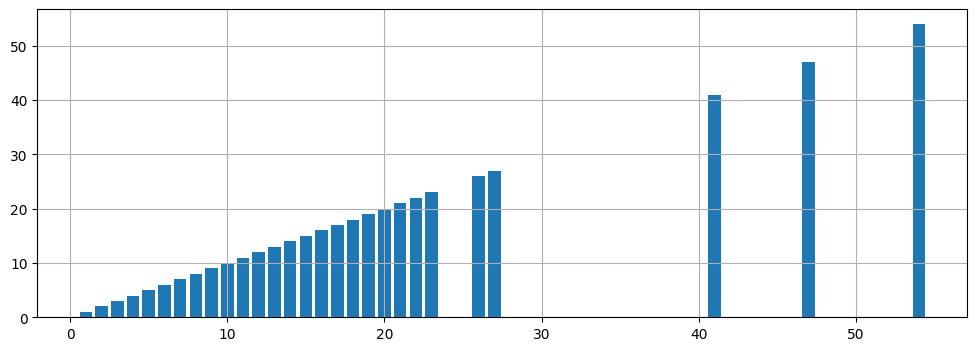

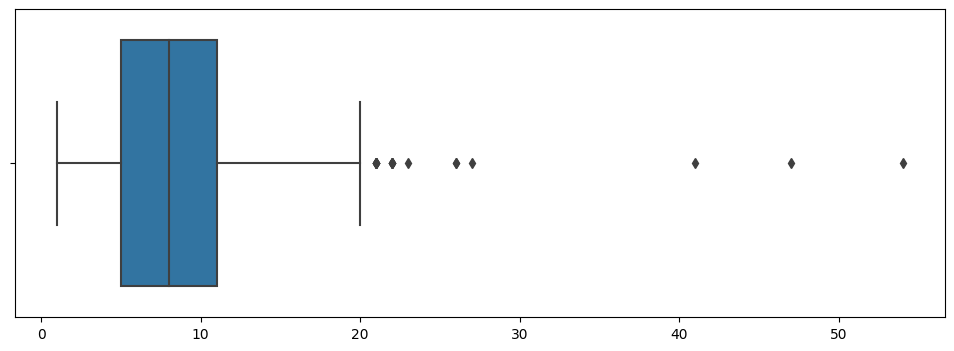

In [693]:
# 문장별 토큰 수 카운트
x_train_token_len = [len(x) for x in x_train]

# 기초 통계량
print("평균 토큰 수:", sum(x_train_token_len) / len(x_train_token_len))
print("최소 토큰 수:", min(x_train_token_len))
print("최대 토큰 수:", max(x_train_token_len))
print("="*50)

# 바 플롯
plt.figure(figsize=(12, 4))
plt.bar(x_train_token_len, x_train_token_len)
plt.grid()
plt.show()

# 박스 플롯
plt.figure(figsize=(12, 4))
sns.boxplot(x=x_train_token_len)
plt.show()

* 문장별 토큰이 가장 큰 것이 57개 입니다.

* 학습 입력을 위한 데이터 크기 맞추기
    * 문장이 짧기 때문에 MAX_SEQUENCE_LENGTH는 정하지 않아도 되지만,
    * 그러나 분포를 보고 적절하게 자릅시다.
    * 그리고 pad_sequences 함수를 이용하여 시퀀스데이터로 변환하기
* y는 train['type'] 와 test['type'] 입니다.

In [694]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [695]:
x_train = pad_sequences(x_train, maxlen=54)
x_val = pad_sequences(x_val, maxlen=54)

y_train = train_data['type']
y_val = test_data['type']

In [696]:
x_train.shape, y_train.shape

((1110, 54), (1110,))

In [697]:
x_train

array([[  0,   0,   0, ..., 473, 474,  14],
       [  0,   0,   0, ..., 473, 474,  14],
       [  0,   0,   0, ..., 687,  26, 161],
       ...,
       [  0,   0,   0, ...,   2,   3,   1],
       [  0,   0,   0, ..., 170,  33, 334],
       [  0,   0,   0, ...,   2,   3,   1]], dtype=int32)

#### 2) 모델링

* 토크나이징 한 데이터를 입력으로 받아
* Embedding 레이어와 LSTM 레이어를 결합하여 이진 분류 모델링을 수행합니다.

In [698]:
max_words = 2000

In [699]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras.layers import Input, LSTM, Flatten, Dense

In [754]:
backend.clear_session()

model_lstm = Sequential()

model_lstm.add(Embedding(max_words, 128, input_length=54))   # 텍스트 데이터 임베딩 벡터로 변환

model_lstm.add(LSTM(64, return_sequences=True))   # 시퀀스 출력 다음 레이어 전달
model_lstm.add(Flatten())
model_lstm.add(Dense(128, activation='relu'))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile( optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # 이진 분류
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 54, 128)           256000    
                                                                 
 lstm (LSTM)                 (None, 54, 64)            49408     
                                                                 
 flatten (Flatten)           (None, 3456)              0         
                                                                 
 dense (Dense)               (None, 64)                221248    
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 526721 (2.01 MB)
Trainable params: 526721 (2.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [755]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=10,
                   verbose=1)

In [756]:
model_lstm.fit(x_train, y_train,
               epochs=1000,
               batch_size=32,
               validation_split=0.2,
               verbose=1,
               callbacks=[es])

Epoch 1/1000
28/28 [==============================] - 7s 105ms/step - loss: 0.5054 - accuracy: 0.7568 - val_loss: 0.4084 - val_accuracy: 0.7748
Epoch 2/1000
28/28 [==============================] - 2s 58ms/step - loss: 0.1271 - accuracy: 0.9550 - val_loss: 0.2096 - val_accuracy: 0.9009
Epoch 3/1000
28/28 [==============================] - 2s 54ms/step - loss: 0.0127 - accuracy: 0.9989 - val_loss: 0.2013 - val_accuracy: 0.9234
Epoch 4/1000
28/28 [==============================] - 1s 52ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.1774 - val_accuracy: 0.9414
Epoch 5/1000
28/28 [==============================] - 2s 80ms/step - loss: 7.3112e-04 - accuracy: 1.0000 - val_loss: 0.2054 - val_accuracy: 0.9459
Epoch 6/1000
28/28 [==============================] - 2s 89ms/step - loss: 3.7850e-04 - accuracy: 1.0000 - val_loss: 0.1995 - val_accuracy: 0.9459
Epoch 7/1000
28/28 [==============================] - 2s 61ms/step - loss: 2.3366e-04 - accuracy: 1.0000 - val_loss: 0.1796 - val_acc

In [757]:
from sklearn.metrics import classification_report, f1_score

In [758]:
model_lstm_pred = model_lstm.predict(x_val)
model_lstm_pred = np.where(model_lstm_pred > 0.5, 1, 0)   #ValueError "Classification metrics can't handle a mix of {0} and {1} targets" 해결

4/4 [==============================] - 1s 16ms/step


In [759]:
print(classification_report(y_val, model_lstm_pred))
print(f1_score(y_val, model_lstm_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       1.00      0.98      0.99        46

    accuracy                           0.99       106
   macro avg       0.99      0.99      0.99       106
weighted avg       0.99      0.99      0.99       106

0.989010989010989


### (2) FastText 모델 : 사전학습된 Word2Vec 모델을 사용

-  FastText 모델 학습을 위한 입력 포맷 2차원 리스트 형태 입니다.
  ```
  [['나', '는', '학생', '이다'], ['오늘', '은', '날씨', '가', '좋다']]
  ```

- Word2Vec계열의 FastText를 학습하는 이유
  - n-gram이 추가된 fasttext 모델은 유사한 단어에 대한 임베딩을 word2vec보다 잘 해결할 수 있으며, 오탈자 등에 대한 임베딩 처리가 가능하다.
  - 예) 체크카드, 쳌카드는 word2vec에서는 전혀 다른 단어이지만 fasttext는 character n-gram으로 비교적 같은 단어로 처리할 수 있다.
- 참고: https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText


#### 1) 데이터 준비
* 시작데이터 : clean_train_questions, clean_test_questions

* FastText를 위한 입력 데이터 구조 만들기

In [761]:
ft_train = [x.split() for x in clean_train_questions]
ft_test = [x.split() for x in clean_test_questions]

#### 2) FastText 모델 생성
* FastText 문법
    * FastText( input데이터,  min_count = , size= , window=  )
        * input데이터 : 학습에 사용할 문장으로 이루어진 리스트
        * min_count : 모델에 사용할 단어의 최소 빈도수. 이 값보다 적게 출현한 단어는 모델에 포함되지 않음. 기본값 = 5
        * size : 단어의 벡터 차원 지정. 기본값 = 100
        * window : 학습할 때 한 단어의 좌우 몇 개의 단어를 보고 예측을 할 것인지를 지정. 기본값 = 5
    * 참조 : https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText

In [762]:
from gensim.models import FastText

model = FastText(ft_train, vector_size=100, window=5, min_count=3)

#### 3) train에 임베딩벡터 결과 저장
* get_sent_embedding 함수를 이용하여 train의 질문별 임베딩 결과를 저장합니다.
    * .apply(lambda .....) 를 활용하세요.

In [763]:
train_data['Embdedding'] = train_data['Q'].apply(lambda sent : get_sent_embedding(model, model.vector_size, sent))

### (3) 챗봇 구축
- input 질문
- intent classifier로 common와 faq 중 하나를 예측
- 예측된 intent에 속한 train의 모든 Q와 input 문장의 임베딩 벡터간의 코사인 유사도 계산
- 코사인 유사도가 가장 높은 top-3개의 Q를 선택
- 선택한 Q에 맵핑된 답변 중 하나를 선택하고 실제 답변과 비교

#### 1) 하나의 질문으로 테스트해보기

* 선택된 질문과 답변

* 예측을 위한 입력 형태로 변환

In [764]:
input = '비대면은 어떻게 진행되나요?'
input_tk = tokenize('mecab', input)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_questions)

input_seq = tokenizer.texts_to_sequences([input_tk])
input_seq = pad_sequences(input_seq, maxlen=54)

* 예측하기

In [765]:
type_pred = model_lstm.predict(input_seq)
type_pred = np.where(type_pred > 0.5, 1, 0)
type_pred

1/1 [==============================] - 0s 30ms/step


array([[1]])

* 질문에 대한 벡터 만들기
    * FestText 모델로 부터 벡터 만들기

In [766]:
embedding_vec = get_sent_embedding(model, model.vector_size, input)
embedding_vec = [list(embedding_vec)]

* train의 질문 벡터들과 유사도 계산
    * FastText 로 만들 벡터들과 유사도 계산

In [767]:
from sklearn.metrics.pairwise import cosine_similarity

temp = train_data.loc[train_data['type'] == type_pred[0][0]].copy()
temp['cosine_similarity'] = temp['Embdedding'].apply(lambda e : max(cosine_similarity(embedding_vec, [list(e)])[0]))
max_idx = temp['cosine_similarity'].idxmax()
temp['A'][max_idx]

'KT 에이블스쿨은 전국 어디서나 참여할 수 있도록, 온/오프라인을 병행하여 탄력적으로 운영합니다.\n오프라인 교육장소는 6개 권역(수도권, 강원권, 부산/경남권, 대구/경북권, 충남/충북권, 전남/전북권)에 위치하고 있습니다. \n\n서류 접수 마감 이후에 지원 지역(교육 장소) 변경은 불가능하며, 최종 합격된 지역에서만 교육이 가능합니다.'

#### 2) 함수로 생성하기

In [768]:
def get_answer2(question):
    input = tokenize('mecab', question)

    input_seq = tokenizer.texts_to_sequences([input])
    input_seq = pad_sequences(input_seq, maxlen=54)

    # type 예측
    type_pred = model_lstm.predict(input_seq)
    type_pred = np.where(type_pred > 0.5, 1, 0)

    # 질문에 대한 벡터 만들기
    embedding_vec = get_sent_embedding(model, model.vector_size, input)
    embedding_vec = [list(embedding_vec)]

    # FastText로 만든 벡터들과 유사도 계산
    temp = train_data.loc[train_data['type'] == type_pred[0][0]].copy()
    temp['cosine_similarity'] = temp['Embdedding'].apply(lambda e : max(cosine_similarity(embedding_vec, [list(e)])[0]))
    max_idx = temp['cosine_similarity'].idxmax()

    return temp['A'][max_idx]

---

#### 3) test 데이터에 대해서 성능 측정하기

test 데이터 전체에 대해서 성능을 측정해 봅시다.

In [770]:
test_data['predicted_answer1'] = test_data['Q'].apply(get_answer1)
test_data['predicted_answer2'] = test_data['Q'].apply(get_answer2)

1/1 [==============================] - 0s 29ms/step


In [771]:
accuracy1 = (test_data['predicted_answer1'] == test_data['A']).mean()
accuracy2 = (test_data['predicted_answer2'] == test_data['A']).mean()

print('Model 1 Accuracy:', accuracy1)
print('Model 2 Accuracy:', accuracy2)

Model 1 Accuracy: 0.0660377358490566
Model 2 Accuracy: 0.5849056603773585


In [717]:
# 자연어 처리 성능 점수?
# from nltk.translate.bleu_score import sentence_bleu

# def calculate_bleu(reference, candidate):
#     reference = [reference.split()]  # BLEU 점수를 계산하기 위해 참조 문장을 단어 리스트로 변환
#     candidate = candidate.split()  # 후보 문장을 단어 리스트로 변환
#     score = sentence_bleu(reference, candidate, weights=(0.5, 0.5))  # BLEU 점수 계산
#     return score

# test_data['bleu_score1'] = test_data.apply(lambda row: calculate_bleu(row['A'], row['predicted_answer1']), axis=1)
# test_data['bleu_score2'] = test_data.apply(lambda row: calculate_bleu(row['A'], row['predicted_answer2']), axis=1)

# average_bleu1 = test_data['bleu_score1'].mean()
# average_bleu2 = test_data['bleu_score2'].mean()

# print('Model 1 Average BLEU Score:', average_bleu1)
# print('Model 2 Average BLEU Score:', average_bleu2)

Model 1 Average BLEU Score: 0.06630343734516737
Model 2 Average BLEU Score: 0.5676499188377857


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


## 5.질문에 대한 답변 비교해보기

* **세부요구사항**
    * 세가지 챗봇을 생성해 보았습니다.
    * 질문을 입력하여 답변을 비교해 봅시다. 어떤 챗봇이 좀 더 정확한 답변을 하나요?


In [775]:
display(get_answer1('에이블스쿨에 지원하고 싶어요'))
display(get_answer2('에이블스쿨에 지원하고 싶어요'))
display('*'*100)
display(get_answer1('비대면 수업 진행이 어떻게 되나요?'))
display(get_answer2('비대면 수업 진행이 어떻게 되나요?'))
display('*'*100)
display(get_answer1('사랑합니다'))
display(get_answer2('사랑합니다'))
display('*'*100)
display(get_answer1('에이블스쿨 어떻게 지원하나요?'))
display(get_answer2('에이블스쿨 어떻게 지원하나요?'))
display('*'*100)
display(get_answer1('교육장 이용 어떻게 하는지 알려주세요'))
display(get_answer2('교육장 이용 어떻게 하는지 알려주세요'))
display('*'*100)
display(get_answer1('노트북'))
display(get_answer2('노트북'))

'직장 스트레스가 심한가봐요.'

1/1 [==============================] - 0s 59ms/step


'취업에 도움이 되는 다양한 프로젝트를 제공하고, 포트폴리오 작성을 도와드리며, 코딩챌린지, 해커톤 등 다양한 Competition 수상 기회를 제공합니다. \n또한, AIVLE Job Fair를 거쳐 우수 수료생을 대상으로 KT와 KT그룹, AI원팀, 협력사 등 채용까지 연계해 드립니다.'

'****************************************************************************************************'

'대중교통을 이용해주세요.'

1/1 [==============================] - 0s 155ms/step


'KT 에이블스쿨은 고용노동부 K-Digital Training 사업으로 운영됨에 따라 총 훈련일수의 80% 이상을 출석한 경우 수료대상이 됩니다.\n반대로, 총 훈련일수의 20%를 초과하여 결석한 경우 제적대상이 됩니다.'

'****************************************************************************************************'

'다 잘 될 거예요.'

1/1 [==============================] - 0s 191ms/step


'다녀오세요. 기다릴게요.'

'****************************************************************************************************'

'힘들 때네요.'

1/1 [==============================] - 0s 150ms/step


'KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업자를 대상으로 하는 교육입니다.\n단, 모집시점에 만 35세여도 해당연도 1월 1일 이후 생일자는 지원이 가능합니다.\n또한 전공의 종류와는 무관 합니다.'

'****************************************************************************************************'

'성공했길 바랍니다.'

1/1 [==============================] - 0s 94ms/step


'KT 에이블스쿨은 전국 어디서나 참여할 수 있도록, 온/오프라인을 병행하여 탄력적으로 운영합니다.\n오프라인 교육장소는 6개 권역(수도권, 강원권, 부산/경남권, 대구/경북권, 충남/충북권, 전남/전북권)에 위치하고 있습니다. \n\n서류 접수 마감 이후에 지원 지역(교육 장소) 변경은 불가능하며, 최종 합격된 지역에서만 교육이 가능합니다.'

'****************************************************************************************************'

'성공을 기원합니다.'

1/1 [==============================] - 0s 47ms/step


'as 맡기세요.'

In [776]:
accuracy1 = (test_data['predicted_answer1'] == test_data['A']).mean()
accuracy2 = (test_data['predicted_answer2'] == test_data['A']).mean()

print('Model 1 Accuracy:', accuracy1)
print('Model 2 Accuracy:', accuracy2)

Model 1 Accuracy: 0.0660377358490566
Model 2 Accuracy: 0.5849056603773585
